# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM) (_optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ASTER Global DEM will be loaded through GEE. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'Wolverine'
# path to snow-cover-mapping/ - Make sure you include a "/" at the end
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to folder containing AOI files
AOI_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/snow_cover_mapping_application/study-sites/' + site_name + '/AOIs/'
# AOI file name
AOI_fn = 'Wolverine_USGS_glacier_outline_2020.shp' 
# path to folder containing DEM raster file
# Note: set DEM_fn=None if you want to use the ArcticDEM or ASTER GDEM via Google Earth Engine
DEM_path = AOI_path + '../DEMs/'
# DEM file name
DEM_fn = 'Wolverine_ArcticDEM_clip.tif'
# path for output images
out_path = AOI_path + '../imagery/'
# path to PlanetScope images
# Note: set PS_im_path=None if not using PlanetScope
PS_im_path = out_path + 'PlanetScope/raw_images/'
# path for output figures
figures_out_path = AOI_path + '../figures/'

# -----Define image search filters
date_start = '2013-05-01'
date_end = '2022-12-01'
month_start = 5
month_end = 10
cloud_cover_max = 70

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest setting mask_clouds = False
mask_clouds = True

# -----Determine image download, clipping & plotting settings
# Note: if im_download = False, but images over the AOI exceed GEE limit,
# images must be downloaded regardless.
im_download = True  # = True to download all satellite images by default
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max(blue) < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCAs and snowlines to file
save_figures = True # = True to save output figures to file

#######################

# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt, dates
import matplotlib
import rasterio as rio
import geopandas as gpd
import pandas as pd
import sys
import ee
import geedim as gd
import json
from tqdm.auto import tqdm
from joblib import dump, load
from shapely.geometry import MultiPolygon, Polygon

# -----Set paths for output files
S2_TOA_im_path = out_path + 'Sentinel-2_TOA/'
S2_SR_im_path = out_path + 'Sentinel-2_SR/'
L_im_path = out_path + 'Landsat/'
PS_im_masked_path = out_path + 'PlanetScope/masked/'
PS_im_mosaics_path = out_path + 'PlanetScope/mosaics/'
im_classified_path = out_path + 'classified/'
snowlines_path = out_path + 'snowlines/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils as f

# -----Load dataset dictionary
dataset_dict = json.load(open(base_path + 'inputs-outputs/datasets_characteristics.json'))

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [2]:
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except: 
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

#### Load AOI and DEM

Optimal UTM CRS = EPSG:32606


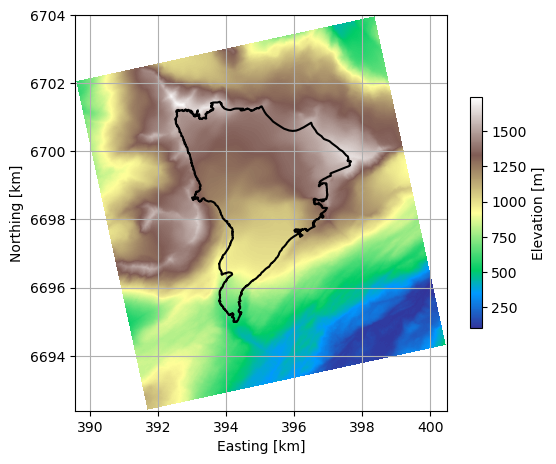

In [3]:
# -----Load AOI as gpd.GeoDataFrame
AOI = gpd.read_file(AOI_path + AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs('EPSG:4326')
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))
# reproject AOI to the optimal UTM zone
AOI_UTM = AOI.to_crs('EPSG:'+epsg_UTM)

# -----Load DEM as Xarray DataSet
if DEM_fn is None:
    # query GEE for DEM
    DEM = f.query_gee_for_dem(AOI_UTM, base_path, site_name, DEM_path)
else:
    # load DEM as xarray DataSet
    DEM = xr.open_dataset(DEM_path + DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject('EPSG:'+str(epsg_UTM))
    DEM = DEM.rio.write_crs('EPSG:'+str(epsg_UTM))
# remove unnecessary data (possible extra bands from ArcticDEM or other DEM)
if len(np.shape(DEM.elevation.data))>2:
    DEM['elevation'] = DEM.elevation[0]
    DEM = xr.where(DEM < -100, np.nan, DEM)
    DEM = DEM.rio.write_crs('EPSG:'+str(epsg_UTM))

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(DEM.elevation.data, cmap='terrain', 
          extent=(np.min(DEM.x.data)/1e3, np.max(DEM.x.data)/1e3, np.min(DEM.y.data)/1e3, np.max(DEM.y.data)/1e3))
if type(AOI_UTM.geometry[0])==Polygon:
    ax.plot([x/1e3 for x in AOI_UTM.geometry[0].exterior.coords.xy[0]],
            [y/1e3 for y in AOI_UTM.geometry[0].exterior.coords.xy[1]], '-k')
elif type(AOI_UTM.geometry[0])==MultiPolygon:
    [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
            [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in AOI_UTM.geometry[0].geoms]
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m]')
plt.show()

## 1. Sentinel-2 TOA imagery

In [ ]:
# -----Query GEE for imagery (and download to S2_TOA_im_path if necessary)
dataset = 'Sentinel-2_TOA'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start, 
                                  month_end, cloud_cover_max, mask_clouds, S2_TOA_im_path, im_download)

Querying GEE for Sentinel-2_TOA imagery...
No image downloads necessary, Sentinel-2_TOA images over the AOI are within the GEE limit.


  0%|          | 0/104 [00:00<?, ?it/s]

Sentinel-2_TOA_20180704.tif: | | 0.00/9.26M (raw) [  0.0%] in 00:00 (eta:     ?)

ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5b28.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5ad8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5ba0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5b78.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5b50.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5ab0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5bc8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5bf0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9f27fc5b00.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7f9fc782b6a8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _

Sentinel-2_TOA_20180828.tif: | | 0.00/9.26M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Sentinel-2_TOA_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Sentinel-2_TOA_feature_columns.json'
feature_cols = json.load(open(feature_cols_fn))

# -----Loop through images
if type(im_list)==str: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, len(im_list))):
        
        # -----Subset image using loop index
        im_xr = im_list[i]
        im_date = str(im_xr.time.data[0])[0:19]
        print(im_date)
        
        # -----Adjust image for image scalar and no data values
        # replace no data values with NaN and account for image scalar
        crs = im_xr.rio.crs.to_epsg()
        if np.nanmean(im_xr['B2'])>1e3:
            im_xr = xr.where(im_xr==dataset_dict[dataset]['no_data_value'], np.nan, 
                             im_xr / dataset_dict[dataset]['image_scalar'])
        else:
            im_xr = xr.where(im_xr==dataset_dict[dataset]['no_data_value'], np.nan, im_xr)
        # add NDSI band
        im_xr['NDSI'] = ((im_xr[dataset_dict[dataset]['NDSI_bands'][0]] - im_xr[dataset_dict[dataset]['NDSI_bands'][1]]) 
                             / (im_xr[dataset_dict[dataset]['NDSI_bands'][0]] + im_xr[dataset_dict[dataset]['NDSI_bands'][1]]))
        im_xr.rio.write_crs('EPSG:'+str(crs), inplace=True)
                
        # -----Classify image
        # check if classified image already exists in file
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
            # remove no data values
            im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr, clf, feature_cols, crop_to_AOI, AOI_UTM, DEM,
                                             dataset_dict, dataset, im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.csv'
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            print(' ')
            continue # no need to load snowline if it already exists
        else:
            snowline_df = f.delineate_snowline(im_xr, im_classified, site_name, AOI_UTM, dataset_dict, dataset, 
                                               im_date, snowline_fn, snowlines_path, figures_out_path, plot_results)
            plt.show()
        print('Accumulation Area Ratio =  ' + str(snowline_df['AAR'][0]))
        print(' ')

## 2. Sentinel-2 SR imagery

In [ ]:
# -----Query GEE for imagery and download to S2_SR_im_path if necessary
dataset = 'Sentinel-2_SR'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start, 
                                  month_end, cloud_cover_max, mask_clouds, S2_SR_im_path, im_download)

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Sentinel-2_SR_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Sentinel-2_SR_feature_columns.json'
feature_cols = json.load(open(feature_cols_fn))

# -----Loop through images
if type(im_list)==str: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, len(im_list))):
        
        # -----Subset image using loop index
        im_xr = im_list[i]
        im_date = str(im_xr.time.data[0])[0:19]
        print(im_date)
        
        # -----Adjust image for image scalar and no data values
        # replace no data values with NaN and account for image scalar
        crs = im_xr.rio.crs.to_epsg()
        if np.nanmean(im_xr['B2'])>1e3:
            im_xr = xr.where(im_xr==dataset_dict[dataset]['no_data_value'], np.nan, 
                             im_xr / dataset_dict[dataset]['image_scalar'])
        else:
            im_xr = xr.where(im_xr==dataset_dict[dataset]['no_data_value'], np.nan, im_xr)
        # add NDSI band
        im_xr['NDSI'] = ((im_xr[dataset_dict[dataset]['NDSI_bands'][0]] - im_xr[dataset_dict[dataset]['NDSI_bands'][1]]) 
                             / (im_xr[dataset_dict[dataset]['NDSI_bands'][0]] + im_xr[dataset_dict[dataset]['NDSI_bands'][1]]))
        im_xr.rio.write_crs('EPSG:'+str(crs), inplace=True)
                
        # -----Classify image
        # check if classified image already exists in file
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
            # remove no data values
            im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr, clf, feature_cols, crop_to_AOI, AOI_UTM, DEM,
                                             dataset_dict, dataset, im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.csv'
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            snowline_df = delineate_snowline(im_xr, im_classified, site_name, AOI_UTM, dataset_dict, dataset, 
                                             im_date, snowline_fn, snowlines_path, figures_out_path, plot_results)
            plt.show()
        print('Accumulation Area Ratio =  ' + str(snowline_df['AAR'][0]))
        print(' ')


## 3. Landsat 8/9 SR

In [ ]:
# -----Query GEE for imagery (and download to L_im_path if necessary)
dataset = 'Landsat'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start, month_end,
                                  cloud_cover_max, mask_clouds, L_im_path, im_download)

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Landsat_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Landsat_feature_columns.json'
feature_cols = json.load(open(feature_cols_fn))

# -----Loop through images
if type(im_list)==str: # check that images were found
    print('No images found to classify, quitting...')
else:
    
    for i in tqdm(range(0, len(im_list))):
        
        # -----Subset image using loop index
        im_xr = im_list[i]
        im_date = str(im_xr.time.data[0])[0:19]
        print(im_date)
        
        # -----Adjust image for image scalar and no data values
        # replace no data values with NaN and account for image scalar
        crs = im_xr.rio.crs.to_epsg()
        # add NDSI band
        im_xr['NDSI'] = ((im_xr[dataset_dict[dataset]['NDSI_bands'][0]] - im_xr[dataset_dict[dataset]['NDSI_bands'][1]]) 
                         / (im_xr[dataset_dict[dataset]['NDSI_bands'][0]] + im_xr[dataset_dict[dataset]['NDSI_bands'][1]]))
        im_xr.rio.write_crs('EPSG:'+str(crs), inplace=True)
                
        # -----Classify image
        # check if classified image already exists in file
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
            # remove no data values
            im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr, clf, feature_cols, crop_to_AOI, AOI_UTM, DEM,
                                             dataset_dict, dataset, im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.csv'
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            snowline_df = f.delineate_snowline(im_xr, im_classified, site_name, AOI_UTM, dataset_dict, dataset, 
                                               im_date, snowline_fn, snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Accumulation Area Ratio =  ' + str(snowline_df['AAR'][0]))
        print(' ')

## 4. PlanetScope SR

In [ ]:
# -----Read surface reflectance image file names
os.chdir(PS_im_path)
im_fns = sorted(glob.glob('*SR*.tif'))

# ----Mask clouds and cloud shadows in all images
plot_results = False
if mask_clouds:
    print('Masking images using cloud bitmask...')
    for im_fn in tqdm(im_fns):
        f.planetscope_mask_image_pixels(PS_im_path, im_fn, PS_im_masked_path, save_outputs, plot_results)
# read masked image file names
os.chdir(PS_im_masked_path)
im_masked_fns = sorted(glob.glob('*_mask.tif'))
    
# -----Mosaic images captured within same hour
print('Mosaicking images captured in the same hour...')
if mask_clouds: 
    f.planetscope_mosaic_images_by_date(PS_im_masked_path, im_masked_fns, PS_im_mosaics_path, AOI_UTM)
    print(' ')
else:
    f.planetscope_mosaic_images_by_date(PS_im_path, im_fns, PS_im_mosaics_path, AOI_UTM)
    print(' ')
    
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/PlanetScope_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/PlanetScope_feature_columns.json'
feature_cols = json.load(open(feature_cols_fn))
dataset = 'PlanetScope'

# -----Adjust image radiometry
# read mosaicked image file names
os.chdir(PS_im_mosaics_path)
im_mosaic_fns = sorted(glob.glob('*.tif'))
# create polygon(s) of the top and bottom 20th percentile elevations within the AOI
polygons_top, polygons_bottom = f.create_aoi_elev_polys(AOI_UTM, DEM)
# loop through images
for im_mosaic_fn in tqdm(im_mosaic_fns[104:]):
    
    # -----Open image mosaic
    im_da = xr.open_dataset(PS_im_mosaics_path + im_mosaic_fn)
    # determine image date from image mosaic file name
    im_date = im_mosaic_fn[0:4] + '-' + im_mosaic_fn[4:6] + '-' + im_mosaic_fn[6:8] + 'T' + im_mosaic_fn[9:11] + ':00:00'
    im_dt = np.datetime64(im_date)
    print(im_date)
    
    # -----Adjust radiometry
    im_adj, im_adj_method = f.planetscope_adjust_image_radiometry(im_da, im_dt, polygons_top, polygons_bottom, dataset_dict, skip_clipped)
    if type(im_adj)==str: # skip if there was an error in adjustment
        continue
    
    # -----Classify image
    im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
    if os.path.exists(im_classified_path + im_classified_fn):
        print('Classified image already exists in file, loading...')
        im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        # remove no data values
        im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
    else:
        im_classified = f.classify_image(im_adj, clf, feature_cols, crop_to_AOI, AOI_UTM, DEM,
                                         dataset_dict, dataset, im_classified_fn, im_classified_path)
    if type(im_classified)==str:
        continue    
    
    # -----Delineate snowline(s)
    plot_results=True
    # check if snowline already exists in file
    snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.csv'
    if os.path.exists(snowlines_path + snowline_fn):
        print('Snowline already exists in file, skipping...')
    else:
        snowline_df = f.delineate_snowline(im_adj, im_classified, site_name, AOI_UTM, dataset_dict, dataset, 
                                           im_date, snowline_fn, snowlines_path, figures_out_path, plot_results)
        plt.show()
        print('Accumulation Area Ratio =  ' + str(snowline_df['AAR'][0]))
    print(' ')

## _Optional_: Compile individual figures into a single .gif file

In [ ]:
### Modify the strings below according to your file names ###

# identify the string that is present in all filenames of the figures that you want to compile
fig_fns_str = '*' + site_name + '_' + dataset + '_*snow-cover.png'
# define the output .gif filename
gif_fn = site_name + '_' + dataset + '_' + date_start.replace('-','') + '_' + date_end.replace('-','') + 'snow-cover.gif' 

# -----Make a .gif of output images
from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image
os.chdir(figures_out_path)
fig_fns = glob.glob(fig_fns_str) # load all output figure file names
fig_fns = sorted(fig_fns) # sort chronologically

# grab figures date range for .gif file name
frames = [PIL_Image.open(im) for im in fig_fns]
frame_one = frames[0]
frame_one.save(figures_out_path + gif_fn, format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
print('GIF saved to file:' + figures_out_path + gif_fn)


# -----Clean up: delete individual figure files
for fn in fig_fns:
    os.remove(os.path.join(figures_out_path, fn))
print('Individual figure files deleted.')

# -----Display .gif
IPy_Image(filename = figures_out_path + gif_fn)